# CSE 144 Spring 2022 Assignment 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class. In the second section, you'll train a simple linear regression model.

You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.

Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 57 points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Specify the epoch number and learning rate (0 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)
    
- Report (10 points, in a separate PDF file)
- Bonus (3 points)
    - If your test loss is below 0.025

In [1]:
!python --version

Python 3.9.7


In [2]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

import random
seed = 144
random.seed(seed)
np.random.seed(seed)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18714 non-null  float64
 1   song_duration_ms  18717 non-null  float64
 2   acousticness      18717 non-null  float64
 3   danceability      18712 non-null  float64
 4   energy            18697 non-null  float64
 5   instrumentalness  18700 non-null  float64
 6   key               18721 non-null  float64
 7   liveness          18695 non-null  float64
 8   loudness          18716 non-null  float64
 9   audio_mode        18715 non-null  float64
 10  speechiness       18727 non-null  float64
 11  tempo             18715 non-null  float64
 12  audio_valence     18709 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


array([[<AxesSubplot:title={'center':'song_popularity'}>,
        <AxesSubplot:title={'center':'song_duration_ms'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'audio_mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'audio_valence'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

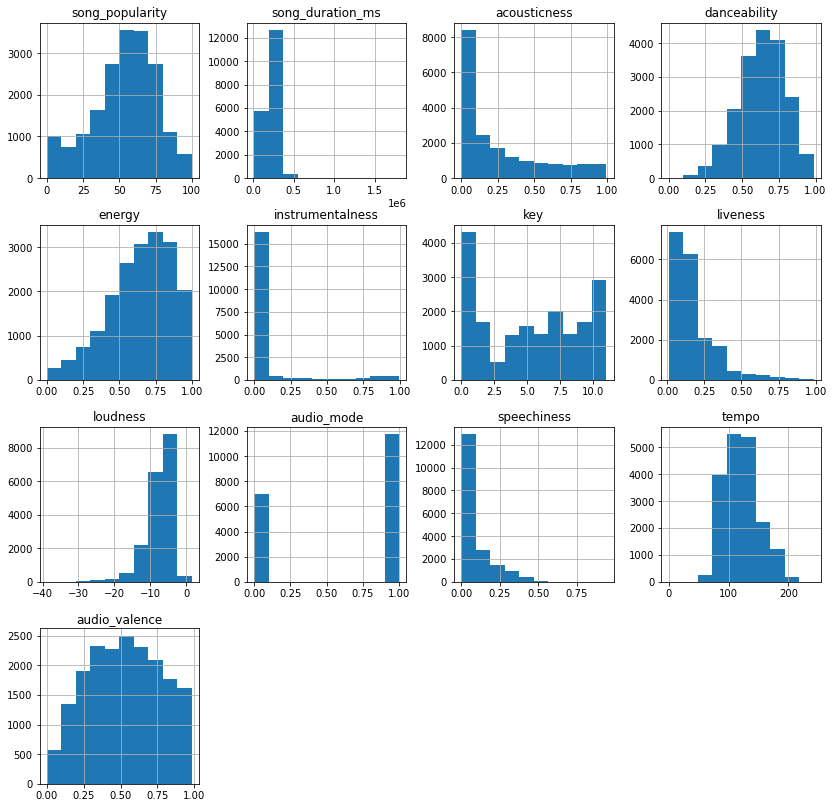

In [3]:
# Load data
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

data = pd.read_csv("./data/song_data.csv", index_col=0).drop(["song_name"], axis = 1)

# Visualize data 
data.info()
data.hist(figsize=(14,14))

### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [4]:
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
data = data.dropna() # Drop all rows containing a NULL for any feature
# ========== YOUR CODE ENDS HERE ============

'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''
for feature in ['song_duration_ms', 'instrumentalness']:
    # ========== YOUR CODE STARTS HERE ==========
    data = data.sort_values(by=feature)
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    a = q1 - (iqr * 1.5)
    b = q3 + (iqr * 1.5)
    print(data)
    print(f"{feature} interval: {(a, b)}")
    data = data.query("@a < @data[@feature] < @b")  
    # ========== YOUR CODE ENDS HERE ============
data = data.reset_index(drop=True)
'''
Scale all independent features using z-score normalization, and normalize dependent feature range to [0, 1]
Note: use different mean and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========
for feature in data:
    if feature != 'song_popularity':
        data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
data['song_popularity'] = (data['song_popularity'] - data['song_popularity'].min()) / data['song_popularity'].max()

# ========== YOUR CODE ENDS HERE ============
data

       song_popularity  song_duration_ms  acousticness  danceability  energy  \
7119               0.0           12000.0      0.700000         0.000   0.493   
18060             37.0           26186.0      0.196000         0.365   0.275   
3726              19.0           31373.0      0.355000         0.273   0.846   
3746              12.0           35920.0      0.826000         0.777   0.376   
4144              61.0           50014.0      0.971000         0.581   0.140   
...                ...               ...           ...           ...     ...   
501               48.0          836666.0      0.043900         0.295   0.568   
16825             33.0          866889.0      0.200000         0.354   0.561   
479               53.0         1233666.0      0.078700         0.345   0.795   
17797             59.0         1355938.0      0.000308         0.197   0.837   
18147             23.0         1799346.0      0.468000         0.737   0.849   

       instrumentalness  key  liveness 

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,audio_valence
0,0.91,-0.686915,0.253264,0.691461,0.484457,-0.349534,0.185625,0.353312,0.652485,0.767237,2.192218,2.058590,1.507623
1,0.37,0.381193,-0.037887,0.919680,0.792608,-0.349534,0.738164,-0.851488,0.300810,-1.303278,-0.379773,0.767026,1.209852
2,0.24,0.381242,-0.185354,1.060639,-0.568392,-0.349534,-0.366913,-0.640509,-0.316890,-1.303278,-0.394635,0.173419,-0.168402
3,0.39,0.382168,-0.706779,1.389543,-0.265377,-0.349534,-1.471991,0.915460,0.748885,0.767237,-0.350050,-0.916949,0.456917
4,0.70,0.382168,-0.748751,1.382831,-0.214018,-0.349534,-1.471991,0.970981,0.704548,0.767237,-0.318469,-0.916984,0.588787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610
12928,0.03,2.457527,-0.901889,0.228310,0.540951,6.426755,1.014433,-0.521140,-0.447550,0.767237,-0.168924,-0.528200,-0.687375
12929,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610
12930,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610


Now we visualize the data again.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932 entries, 0 to 12931
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   12932 non-null  float64
 1   song_duration_ms  12932 non-null  float64
 2   acousticness      12932 non-null  float64
 3   danceability      12932 non-null  float64
 4   energy            12932 non-null  float64
 5   instrumentalness  12932 non-null  float64
 6   key               12932 non-null  float64
 7   liveness          12932 non-null  float64
 8   loudness          12932 non-null  float64
 9   audio_mode        12932 non-null  float64
 10  speechiness       12932 non-null  float64
 11  tempo             12932 non-null  float64
 12  audio_valence     12932 non-null  float64
dtypes: float64(13)
memory usage: 1.3 MB


array([[<AxesSubplot:title={'center':'song_popularity'}>,
        <AxesSubplot:title={'center':'song_duration_ms'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'danceability'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'audio_mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'audio_valence'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

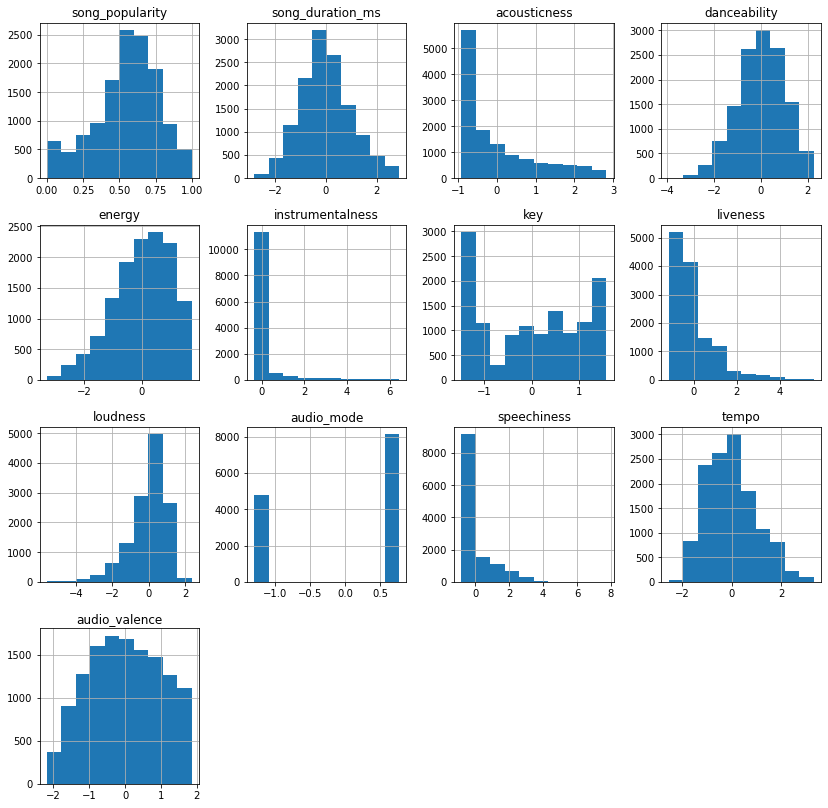

In [5]:
data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [6]:
def test_split(data, test_size: float=0.3, seed=seed):
    '''
    Use function train_test_split() to split test set.
    '''
    # ========== YOUR CODE STARTS HERE ==========
    # I think data is an df
    X = data.iloc[:, 1::]
    y = data.iloc[:, 0:1]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)
    # ========== YOUR CODE ENDS HERE ============
    
    return (X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    '''
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]
                    
    '''
    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)] # Grabs data and organizes indices into k lists, each list containing 1/k indices of all data to reserve for validation
    train_val_pairs = [(None, None, None, None) for _ in range(k)]
    # ========== YOUR CODE STARTS HERE ==========
    for i, pairs in enumerate(train_val_pairs):  # i is a fold from k folds
        anti_index_split = [index_split_list[j] for j in range(len(index_split_list)) if j != i] # Basically grabs all partitions that aren't the ith partition
        anti_index_split_list = [] # After loop, concats all k-1 partitions (excluding ith partition) and contains idxes of all entries to use for training (not validation)
        for idxPair in anti_index_split: # anti_index_split is a list containing k-1 index pairs 
            anti_index_split_list += idxPair # concats a partition of indices for training at a time
        '''
        ex: for 1st validation partion from k partitions for validation
        index_split_list      = [2,5] (validation indices) 
        anti_index_split_list = [1,6,3,8,9,4,0,7] (training indices)
        '''


        valFilter = [False] * X_train_val.shape[0] # List which will be: True for validation entries, False o.w. (apply this to data)
        trainFilter = [False] * X_train_val.shape[0] # List which will be: True for training entries, False o.w. (apply this to data)
        for idx in index_split_list[i]:
            valFilter[idx] = True
        for idx in anti_index_split_list:
            trainFilter[idx] = True
    
        X_vali = X_train_val[valFilter] 
        y_vali = y_train_val[valFilter]
        X_traini = X_train_val[trainFilter]
        y_traini = y_train_val[trainFilter]
        train_val_pairs[i] = (X_traini, y_traini, X_vali, y_vali)            
    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs

X_train_val, y_train_val, X_test, y_test = test_split(data)
train_val_pairs = train_val_split(X_train_val, y_train_val)

In [7]:
train_val_pairs


[(      song_duration_ms  acousticness  danceability    energy  \
  2            -0.794023     -0.868614      1.040502 -0.059943   
  3             1.603831      0.551978      0.899543 -0.630022   
  4             0.875651     -0.861430      0.416255  0.119812   
  5            -0.334991     -0.675774      0.731735  0.926140   
  6             0.937409     -0.918204     -0.073745 -0.131845   
  ...                ...           ...           ...       ...   
  9044         -0.997365      1.198561     -0.859088 -0.578663   
  9045         -0.774176     -0.865211     -0.402649  0.638533   
  9046         -0.792780     -0.276102      0.067214 -0.214018   
  9047          0.473184      1.315777      0.993516 -1.076840   
  9051          2.626564     -0.859539      0.013515  0.874782   
  
        instrumentalness       key  liveness  loudness  audio_mode  speechiness  \
  2            -0.349534 -1.195721 -0.507259  0.522496    0.767237     0.325225   
  3            -0.248770  0.738164 -0.9

In [8]:
# Confirm that 30% split for test-training was used
print(f"data shape: {data.shape}")
print(f"X_train shape: {X_train_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"test set proportion: {100 * X_test.shape[0]/data.shape[0] :.02f}%") 

data shape: (12932, 13)
X_train shape: (9052, 12)
X_test shape: (3880, 12)
test set proportion: 30.00%


In [9]:
aa = np.array([[1,2,3], [4,5,6]])
np.c_[np.ones(2), aa]
aa.shape

(2, 3)

In [10]:
np.random.rand(5,1) < np.random.rand(5,1)

array([[ True],
       [False],
       [ True],
       [ True],
       [False]])

## Linear regression

Hint: A convenient way to calculate $X \cdot \theta$ is to prepend a column of 1's to your $X$ matrix so that you don't have to perform an extra addition operation. If you used this implementation, please also add an additional dimension to your feature matrix so that they are consistent in shape. See the image below for illustration. See this [illustration](https://cs231n.github.io/linear-classify/#:~:text=Illustration%20of%20the,and%20the%20biases.) for more detail.

You report should include the train, val and test loss. You can try different learning rates and epoch combinations and report the best results you get based on the validation loss.

Final train loss for the best model: 0.022931613607033417
Final validation loss for the best model: 0.023065865240629497
Parameters for the best model: [[ 0.548354  ]
 [ 0.00414595]
 [-0.01696925]
 [ 0.02752383]
 [-0.02513786]
 [-0.01211507]
 [-0.00378354]
 [-0.00529212]
 [ 0.03509819]
 [-0.00134353]
 [-0.00640564]
 [-0.00064217]
 [-0.02359534]]


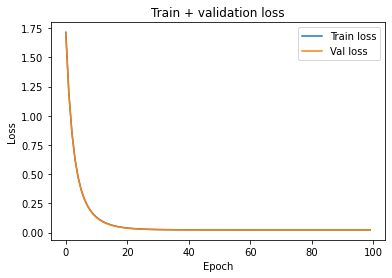

Test loss: song_popularity    0.023009
dtype: float64


In [11]:
def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    error = pred - target
    squareError = error ** 2
    sumSE = squareError.sum()
    mseLoss = sumSE/(2*len(pred))
    return mseLoss # return a float or something
    
    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
#     X = np.array([np.ones(len(theta)), X]) # each list entry becomes a row in a mat (1x2 time 2xm), so matmul theta x X -> (1,m)
#     print(f"shape of X: {X.shape}")
#     print(f"shape of theta: {theta.shape}")
#     print(f"shape of y: {y.shape}")
    innerProd = (np.matmul(X, theta)) - y
    grad = np.matmul(np.transpose(X), innerProd)/X.shape[0]  # from formula on L5 slides, slide 13:  X x Theta = (num entries, num feats) x (num feats, 1)
    return grad # returns a list of factors for which to update each theta by (after multiplying by learning rate)
    # ========== YOUR CODE ENDS HERE ============ 
# shape of X: (7241, 13)
# shape of theta: (13, 1)
# shape of y: (7241, 1)
# Specify epoch and learning rate
# ========== YOUR CODE STARTS HERE ==========
num_epochs = 100
learning_rate = 1e-1
# ========== YOUR CODE ENDS HERE ============ 
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = None
loss_min = None

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]
    
    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    X_train, y_train, X_val, y_val = X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy()
    X_train = np.c_[np.ones(len(X_train)), X_train]
    X_val = np.c_[np.ones(len(X_val)), X_val]
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.random.rand(X_train.shape[1],1)
    # ========== YOUR CODE ENDS HERE ============
#     print(theta.shape)
#     print(X_train.shape)
    for epoch in range(num_epochs):
#     for epoch in trange(num_epochs, desc="Epoch"):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========
        pass
        train_pred = np.matmul(X_train, theta)
        val_pred = np.matmul(X_val, theta)
        train_loss_history[i].append( MSE_loss(train_pred, y_train) )
        val_loss_history[i].append( MSE_loss(val_pred, y_val))
        # ========== YOUR CODE ENDS HERE ============
        
        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        theta = theta - learning_rate*gradient(X_train, y_train, theta)
        # ========== YOUR CODE ENDS HERE ============

    
    # Inference on validation set, and find the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
    if i == 0:
        index_min = i
        loss_min = train_loss_history[i][-1]
    else:
        if train_loss_history[i-1][-1] > train_loss_history[i][-1]:
            index_min = i
            loss_min = train_loss_history[i][-1]
            theta_min = theta
    
    # ========== YOUR CODE ENDS HERE ============
# print(train_loss_history)
print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print(f"Parameters for the best model: {theta_min}")

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========
X_test = np.c_[np.ones(len(X_test)), X_test]
# print(X_test.shape)
test_pred = np.matmul(X_test, theta_min)
test_loss = MSE_loss(test_pred, y_test)
# ========== YOUR CODE ENDS HERE ============                  
print(f"Test loss: {test_loss}")